In [88]:
import os
import sys
import pandas as pd
import networkx as nx
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pycausal.pycausal import pycausal

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from aitia_explorer.app import App

# stop the warning clutter
import warnings
warnings.filterwarnings('ignore')

In [29]:
pc = pycausal()
pc.start_vm()

In [30]:
aitia = App()

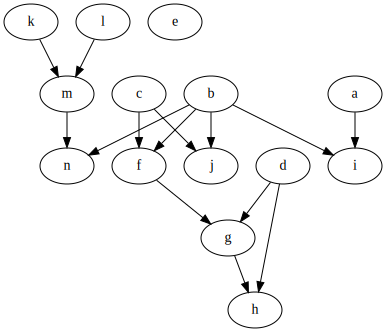

In [31]:
scm3 = aitia.data.scm3()
scm3.cgm.draw()

In [32]:
target_graph_str = str(scm3.cgm.draw())

In [33]:
df = scm3.sample(2000)
df

,l,k,m,e,d,c,b,n,j,f,g,h,a,i
0,-0.446861,-0.664398,-2.049375,-0.172754,1.148097,-0.624837,1.376594,1,1,1,2.241751,4.088695,0.703824,1
1,1.199180,-0.297738,1.451652,1.778341,0.612752,-0.036102,0.776194,1,1,1,1.762088,-0.027129,-2.998218,1
2,-1.066346,-0.279457,-1.633960,1.385960,0.506808,-1.048200,-1.051892,1,1,1,0.939943,0.724288,0.671488,1
3,-0.923830,-1.438188,-2.892983,-0.090182,-3.037087,-1.002100,-0.882888,1,0,1,-2.867398,-3.673240,0.439817,0
4,-0.677983,-0.761617,-0.771844,0.428498,0.994565,0.672693,-0.521106,0,0,0,2.770861,2.738348,0.705083,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.447146,-0.467574,0.786288,0.416453,-1.257680,-0.710885,0.732895,1,1,0,-1.332653,-2.370841,0.676106,0
1996,-1.995757,-0.679261,-2.445252,0.736431,1.185785,-0.235413,-0.893933,1,0,1,2.578078,2.647063,0.417086,1
1997,-0.234546,0.199300,0.841131,1.112498,-0.223286,0.175589,1.107422,1,0,0,-1.444878,-4.467412,1.062664,1
1998,0.442644,0.577967,0.890483,-1.455433,0.873846,0.884068,-1.700574,0,0,0,0.329257,1.372871,-0.909287,0


In [34]:
analysis_results, summary = aitia.run_analysis(df, 
                                               target_graph_str=target_graph_str, 
                                               algorithm_list=[
                                                   aitia.algo_runner.PC,
                                                   aitia.algo_runner.FCI
                                               ],
                                               pc=pc)
summary

,Algorithm,Isomorphic to Target?,AURC,SHD
0,PC,False,1.0,0
1,FCI,False,1.0,0


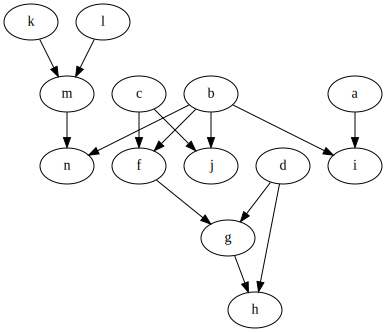

In [9]:
analysis_results[0]['causal_graph'].draw()

In [35]:
df = df.drop(['b'], axis=1)
df = df.drop(['d'], axis=1)
df = df.drop(['m'], axis=1)

In [91]:
# after the columns have been dropped
analysis_results, summary = aitia.run_analysis(df, 
                                               target_graph_str=target_graph_str, 
                                               algorithm_list=[
                                                    aitia.algo_runner.PC,
                                                   aitia.algo_runner.FCI,
                                                   aitia.algo_runner.FGES_continuous,
                                                   aitia.algo_runner.GFCI_continuous,
                                                   aitia.algo_runner.RFCI_continuous,
                                               ],
                                               pc=pc)
summary

,Algorithm,Isomorphic to Target?,AURC,SHD
0,PC,False,0.380102,18
1,FCI,False,0.380102,18
2,FGES-continuous,False,0.368197,19
3,GFCI-continuous,False,0.380102,18
4,RFCI-continuous,False,0.380102,18


In [36]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [39]:
# see https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
n_clusters=np.arange(2, 10)
bics=[]
bics_err=[]
iterations=20
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=mixture.GaussianMixture(n, n_init=2).fit(X) 
        tmp_bic.append(gmm.bic(X))
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

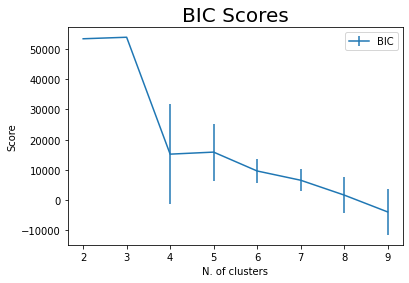

In [40]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

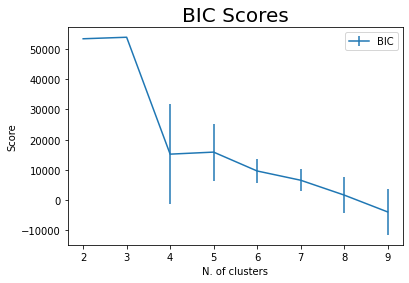

In [41]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

In [71]:
n_clusters=np.arange(2, 10)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=mixture.GaussianMixture(n, n_init=2).fit(X) 
        labels=gmm.predict(X)
        sil=metrics.silhouette_score(X, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Text(0, 0.5, 'Score')

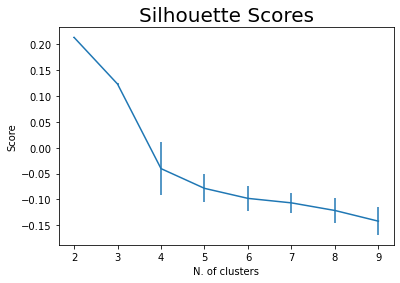

In [72]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

In [86]:

#Courtesy of https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms. Here the difference is that we take the squared root, so it's a proper metric

def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

In [89]:
n_clusters=np.arange(2, 10)
iterations=20
results=[]
res_sigs=[]
for n in n_clusters:
    dist=[]
    
    for iteration in range(iterations):
        train, test=train_test_split(X, test_size=0.5)
        
        gmm_train=mixture.GaussianMixture(n, n_init=2).fit(train) 
        gmm_test=mixture.GaussianMixture(n, n_init=2).fit(test) 
        dist.append(gmm_js(gmm_train, gmm_test))
    selec=SelBest(np.array(dist), int(iterations/5))
    result=np.mean(selec)
    res_sig=np.std(selec)
    results.append(result)
    res_sigs.append(res_sig)

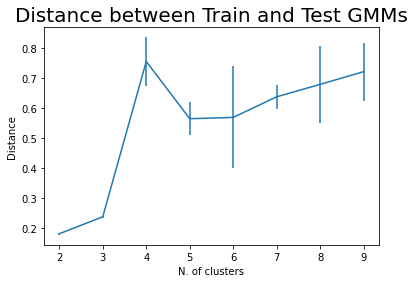

In [90]:

plt.errorbar(n_clusters, results, yerr=res_sigs)
plt.title("Distance between Train and Test GMMs", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Distance")
plt.show()

In [45]:
X.shape

(2000, 12)

In [82]:
X = df
from sklearn import mixture
gmm = mixture.BayesianGaussianMixture(n_components=3).fit(X)
labels = gmm.predict(X)

In [83]:
data_new = gmm.sample(2000)
X_new = pd.DataFrame(data_new[0], columns=list(X))
X_new

,l,k,e,c,n,j,f,g,h,a,i
0,-0.887992,-1.381026,1.094347,-0.737377,0.974103,0.885856,1.196508,0.235878,-0.320170,0.212388,1.428409
1,1.505700,-0.773308,-0.739445,0.146245,1.026160,-0.409524,1.296977,-0.148002,-1.913557,-1.618456,-0.081092
2,0.095990,-0.848689,-0.196564,-1.044732,0.992606,1.001265,1.264394,0.478371,1.251065,-0.009706,0.492155
3,-0.645064,-0.413295,0.007980,-1.197905,0.989748,0.494248,1.328212,0.232334,1.215536,-0.524969,1.555872
4,0.651272,1.212379,1.806593,0.503013,1.054150,0.577197,-0.465251,2.696942,2.680154,-0.256045,0.174584
...,...,...,...,...,...,...,...,...,...,...,...
1995,0.963749,-1.427907,0.240793,0.043316,0.016260,0.803399,0.883164,-0.784029,-0.713046,-2.185597,1.077571
1996,-2.175823,0.488849,-0.160170,0.460308,0.002315,-0.314339,0.072554,1.488879,1.333377,-0.102717,-0.015438
1997,0.028842,1.018745,-0.858101,0.153954,0.008977,0.513655,0.870420,2.066515,1.545216,0.086353,0.014752
1998,-0.240752,0.516003,0.783151,0.492765,0.042826,1.204731,0.003969,1.181645,2.085395,0.839264,0.319137


In [84]:
analysis_results2, summary2 = aitia.run_analysis(X_new, 
                                               target_graph_str=target_graph_str, 
                                               algorithm_list=[
                                                   aitia.algo_runner.PC,
                                                   aitia.algo_runner.FCI,
                                                   aitia.algo_runner.FGES_continuous,
                                                   aitia.algo_runner.GFCI_continuous,
                                                   aitia.algo_runner.RFCI_continuous,
                                               ],
                                               pc=pc)
summary2

,Algorithm,Isomorphic to Target?,AURC,SHD
0,PC,False,0.409864,16
1,FCI,False,0.409864,16
2,FGES-continuous,False,0.393838,17
3,GFCI-continuous,False,0.409864,16
4,RFCI-continuous,False,0.409864,16


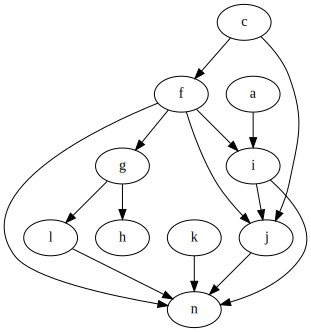

In [62]:
analysis_results2[3]['causal_graph'].draw()

In [93]:
summary # without clustering

,Algorithm,Isomorphic to Target?,AURC,SHD
0,PC,False,0.380102,18
1,FCI,False,0.380102,18
2,FGES-continuous,False,0.368197,19
3,GFCI-continuous,False,0.380102,18
4,RFCI-continuous,False,0.380102,18


In [ ]:
summary2 # with c